In [1]:
import numpy as np
np.__version__

import pandas as pd
pd.__version__

import matplotlib as plt
plt.__version__

import sys 
sys.version_info

%matplotlib inline

import textwrap
import os
import openpyxl
import copy
import time
from tabulate import tabulate
import seaborn as sns 

import matplotlib.pyplot as plt 

# Parameters

In [2]:
#PRINT_HEAD set to 1 prints always first X (PRINT_ROWS) of the manipulated dataframe after the operation
PRINT_HEAD = 0
PRINT_ROWS = 1
NUMBER_PRINT = 30

# dateframe header row 
DF_HEADER = 9

#CityCode Column Name
ccc_name = 'Region Code'
cnc_name = 'Region Name'
#CityDate Column Name
cdc_name = 'Data Type'

image_format = 'png' # e.g .png, .svg, etc.

# Functions

## Print-Dict

In [3]:
def print_dict(dict, row_count=NUMBER_PRINT):
    if PRINT_ROWS == 1:
        #The following codes displays the first X (NUMBER_PRINT) rows of the manipulated data frame(s)
        for data_key, data_value in dict.items():
            print("data_key: " + data_key + " rows# " + str(data_value.shape[0]))
            print(data_value.sort_values(by=ccc_name).head(row_count).to_markdown())
            print('\n\n')

## Read Workbook Sheets

In [4]:
# read_wb
# Opens an excel sheet and reads each sheet in a seperate df
# The df_list argument allows to specify the sheets to be read or avoided (when avoid parameter = True)
# returns a dictionary of dfs where each key is obtained from a fixed cell value in the sheet
# and the df as value

def read_wb(file_path, df_list, avoid):
    df_dict = {}
    try:
        wb = openpyxl.load_workbook(filepath)
    except:
        print("Can't open file")
        return 0
    else:
        for sheet in wb.sheetnames:
            if avoid == True:
                if sheet not in df_list:
                    df_dict[wb[sheet].cell(6,3).value] = pd.read_excel(file_path, sheet, header=DF_HEADER)  
            else:
                if sheet in df_list:
                    df_dict[sheet] = pd.read_excel(file_path, sheet, header=DF_HEADER)  
                
        return df_dict

## Unpack DF Dictionary

In [5]:
import copy
def unpack_df_dict(df_dict, new_dict, key=""):
    if isinstance(df_dict, pd.DataFrame):
        new_dict[key] = copy.deepcopy(df_dict)
    else:      
        for data_key, data_value in df_dict.items():
            unpack_df_dict(data_value, new_dict, str(key)[:15] + "-" + data_key)

## Select DF Time Range

In [6]:
# select_df_time_range
# input: df_dict - dictionary of dataframes to select data from 
# input: fr_yr - defines the year to start the selection from
# input: to_yr - defines the year to end the selection
# return: data_dict_range - dicionary of updated dataframes with data from year to year

def select_df_time_range(df_dict, fr_yr, to_yr):

    #The following procedure iterates over all dataframes in each dictionaries referenced in the data_dict_raw
    #dictionary (a deep copy of data_dict_raw_or) and casts all data from the second column onwards to an numeric data type

    data_dict_range = {}
    
    for data_key, data_value in df_dict.items():         
        try:
            temp_df = pd.concat([data_value.iloc[:,0:2], data_value.iloc[:, data_value.columns.get_loc(str(fr_yr)):(data_value.columns.get_loc(str(to_yr))+1)].\
                                 apply(pd.to_numeric, downcast='integer', errors='coerce')], axis=1)
            data_dict_range[data_key] = temp_df.rename(columns={'TIME' : ccc_name, 'TIME.1' : cnc_name})
        except:
            print(data_key)
            print(data_value.head(30).to_markdown())
        
    return data_dict_range

## Interpolate

In [7]:
# augment_df_delnan_int
# Augments data frames received by a dict and
# (a) deletes rows above the nan_thres (NaN Values Threshold)
# (b) fills data voids via linear interpolation
# (c) deletes rows with empty values and returns augmented df in a dict

def augment_df_delnan_int(df_dict, nan_thres):
    
    data_dict_clean = {}
    
    #The following process iterates over all dataframes and deletes all rows where
    #more than half of the year-range (y_range_to - y_range_from) is missing
    for data_key, data_value in df_dict.items(): 
        data_dict_clean[data_key] = data_value.dropna(axis='index', thresh=nan_thres, ignore_index=True)
    
    #The following process iterates over all dataframes and filles data voids 
    #via the linear interpolation method. The limit is set to y_half +1 to allow for 
    #the interpolation of missing data within the previously defined limitations
    #i.e. delete row with a number of missing values larger than y_half
    
    for data_key, data_value in data_dict_clean.items(): 
        temp_data = data_value.iloc[:,2:].interpolate(method='linear', axis='columns', limit=(nan_thres+1), limit_direction='both')
        data_dict_clean[data_key] = pd.concat([data_value.iloc[:,0:2], temp_data], axis=1);

    #The following codes deletes all remaining rows that have empty fields
    for data_key, data_value in data_dict_clean.items():
        data_dict_clean[data_key] = data_value.dropna(axis='index', how='any')

    # Prints rows with remaining empty fields if there are any
    for data_key, data_value in data_dict_clean.items():
        if data_value.isnull().any().any() == True:
            print(data_value.isnull().any())
            print(data_key)
            print(data_value.head(500).to_markdown())

    # Returns augmented df in a dictionary
    return data_dict_clean
    

## Add Delta

In [8]:
# add_delta - adds absolute and relative delta to dataframes
# input: df_dict - dataframe dictionary
# input: fr_yr - start year for the calculation of data delta
# input: to_yr - end year for the calcuation of data delta
# return: data_dict_delta - dictionary of dataframes with absolute and relative delta added

def add_delta(df_dict, fr_yr, to_yr):
    data_dict_delta = {}    
    
    for data_key, data_value in df_dict.items():  
        try:
            if 'Delta' not in data_value:
                df_fr_yr = data_value.loc[:, str(fr_yr)]
                df_to_yr = data_value.loc[:, str(to_yr)]
                
                delt_ab = df_to_yr.sub(df_fr_yr)
                delt_pr = ((df_to_yr.sub(df_fr_yr)).div(df_fr_yr)).mul(100)
                
                delta = pd.concat([delt_ab, delt_pr], axis=1)
                delta.columns = ['Delta Abs.', 'Delta %']
                data_dict_delta[data_key] = pd.concat([data_value, delta], axis=1)
        except: 
            print(data_key)
            print(data_value.head(30).to_markdown())            

    data_dict_delta = check_rates(data_dict_delta, fr_yr, to_yr)
    return data_dict_delta
                

## Check for Rates in Delta

In [9]:
# check_rates - replaces relative deltas if values in dataframe are in percentage
# input: df_dict - dataframe dictionary
# input: fr_yr - start year for the calculation of data delta
# input: to_yr - end year for the calcuation of data delta
# return: data_dict_delta - dictionary of dataframes with absolute and relative delta added

def check_rates(df_dict, fr_yr, to_yr):
    data_dict_delta_rates = {}    
    
    for data_key, data_value in df_dict.items():             
        if 'ratio' in data_key:
            data_value.loc[:,'Delta %'] = data_value.loc[:, 'Delta Abs.']
        elif ((data_value.iloc[:,data_value.columns.get_loc(str(fr_yr)):data_value.columns.get_loc(str(to_yr))] > 101).any()).any() == False:
            data_value.loc[:,'Delta %'] = data_value.loc[:, 'Delta Abs.']
            
        data_dict_delta_rates[data_key] = data_value
                             
    return data_dict_delta_rates

## Select Dataframe

In [10]:
# select_df - combines seperate dataframes from a data frame dicionary in a single dataframe
# input: df_dict - dataframe dictionary to source data frames
# input: df_list - list of dataframes names to add to the new dataframe as key of the df_dict
# input: avoid - When true the dataframes listed in df_list will be excluded in the selection
# return: result - dataframes combining selection of dataframes listed in df_list

def select_df(df_dict, df_list, avoid):
    tmp_df = pd.DataFrame()
    result = pd.DataFrame()
    
    for key, value in df_dict.items():
        tmp_df = value.copy(deep=True)
        tmp_df.insert(2, str(cdc_name), str(key), allow_duplicates=True)
        if avoid == False:
            if key in df_list:
                result = pd.concat([result, tmp_df], axis=0, ignore_index=True)
        else:
            if key not in df_list:
                result = pd.concat([result, tmp_df], axis=0, ignore_index=True)
    return result.reset_index(drop=True)

## Aggregate DF

In [11]:
# aggregate_df_values - aggregates the values of a dataframe based on regions and data features
# input: df_raw - dataframe of regional values to be aggregated
# return: agg_df - aggregated dataframe without nan value fields

def aggregate_df_values(df_raw):

    # Creates a list of all regions in the dataframe
    agg_functions = {cnc_name: 'first'}
    agg_df = df_raw.groupby(df_raw[ccc_name]).aggregate(agg_functions)

    # Creates a list of data features in the datafarame (cdc_name = Data feature name)    
    data_list = sorted(set(pd.unique(df_raw[cdc_name])))

    # Iterates over the list of data features and joins values of regions in the previously
    # defined df with all regions found in the df_raw
    for data_instance in data_list:
        tmp_df = df_raw[df_raw[cdc_name] == data_instance]
        
        tmp_df = tmp_df.set_index([ccc_name], drop=True)        
        tmpp_df = pd.concat([tmp_df.iloc[:,0:0], tmp_df.iloc[:,-1:]], axis='columns')
        tmpp_df = tmpp_df.rename(columns={'Delta %' : str('Δ ' + str(data_instance))})
        tmpp_df = tmpp_df.sort_values([ccc_name])

        try:
            agg_df = agg_df.join(tmpp_df, on=ccc_name, lsuffix='left*')
        except:
            print(agg_df.head(10).to_markdown())
            print(tmpp_df.head(10).to_markdown())

    # Drops records of regions that do not provide values in all features
    agg_df = agg_df.dropna(axis='index', how='any')
    
    return agg_df

## Remove Outliers

In [12]:
def remove_outliers(df_data, col_name, quan_size):
    Q1 = df_data[col_name].quantile(quan_size)
    Q3 = df_data[col_name].quantile((1-quan_size))
    IQR = Q3 - Q1
    
    threshold = 1.5
    outliers = df_data[(df_data[col_name] < Q1 - threshold * IQR) | (df_data[col_name] > Q3 + threshold * IQR)]
    return df_data.drop(outliers.index)

## Counting Data

In [13]:
def count_df_values(df_dict):
    datapoints = 0
    for key, value in df_dict.items():
        datapoints = datapoints + value.count().sum()
    return datapoints

# Loading Data

In [14]:
dir_path = "Analysis_EconomicPerformance_SectoralEmployment/"
extension = '.xlsx'
files = os.listdir(dir_path)
xlsx_files = [file for file in files if os.path.splitext(file)[1] == extension]
print(xlsx_files)

['001 - GDP-MP.xlsx', '001 - GDP-VL.xlsx', '002 - EM-SEC.xlsx']


In [15]:
df_list = ['Summary', 'Structure']

data_dict_raw_or = {}
for file in xlsx_files:
    filepath = dir_path + file
    data_dict_raw_or[file] = read_wb(filepath, df_list, True)
    

In [16]:
datapoints = 0
for key, value in data_dict_raw_or.items():
    datapoints = datapoints + count_df_values(value)
print(datapoints)

82625


# Font Section

In [17]:
title_font = {'family':'serif','color':'blue','size':18}
subtitle_font = {'family':'serif','color':'black','size':12}

corr_fontdict_hor = {
    'verticalalignment': 'center',
    'horizontalalignment': 'right'}

corr_fontdict_vert = {
    'verticalalignment': 'top',
    'horizontalalignment': 'center'}

In [18]:
corr_Indi01 = 'Economic Development '
corr_Indi02 = 'Sectoral Employment ' 
fig_x = 14
fig_y = 14

line_break_at = 45

y_range_fr_ful = 2008
y_range_to_ful = 2022

y_range_fr_ear = 2008
y_range_to_ear = 2015

y_range_fr_lat = 2016
y_range_to_lat = 2022

# Select Dataframes

## Select Full Data Frame

66575
70091
70091
Before outliers:(239, 14)
After outliers:(143, 14)


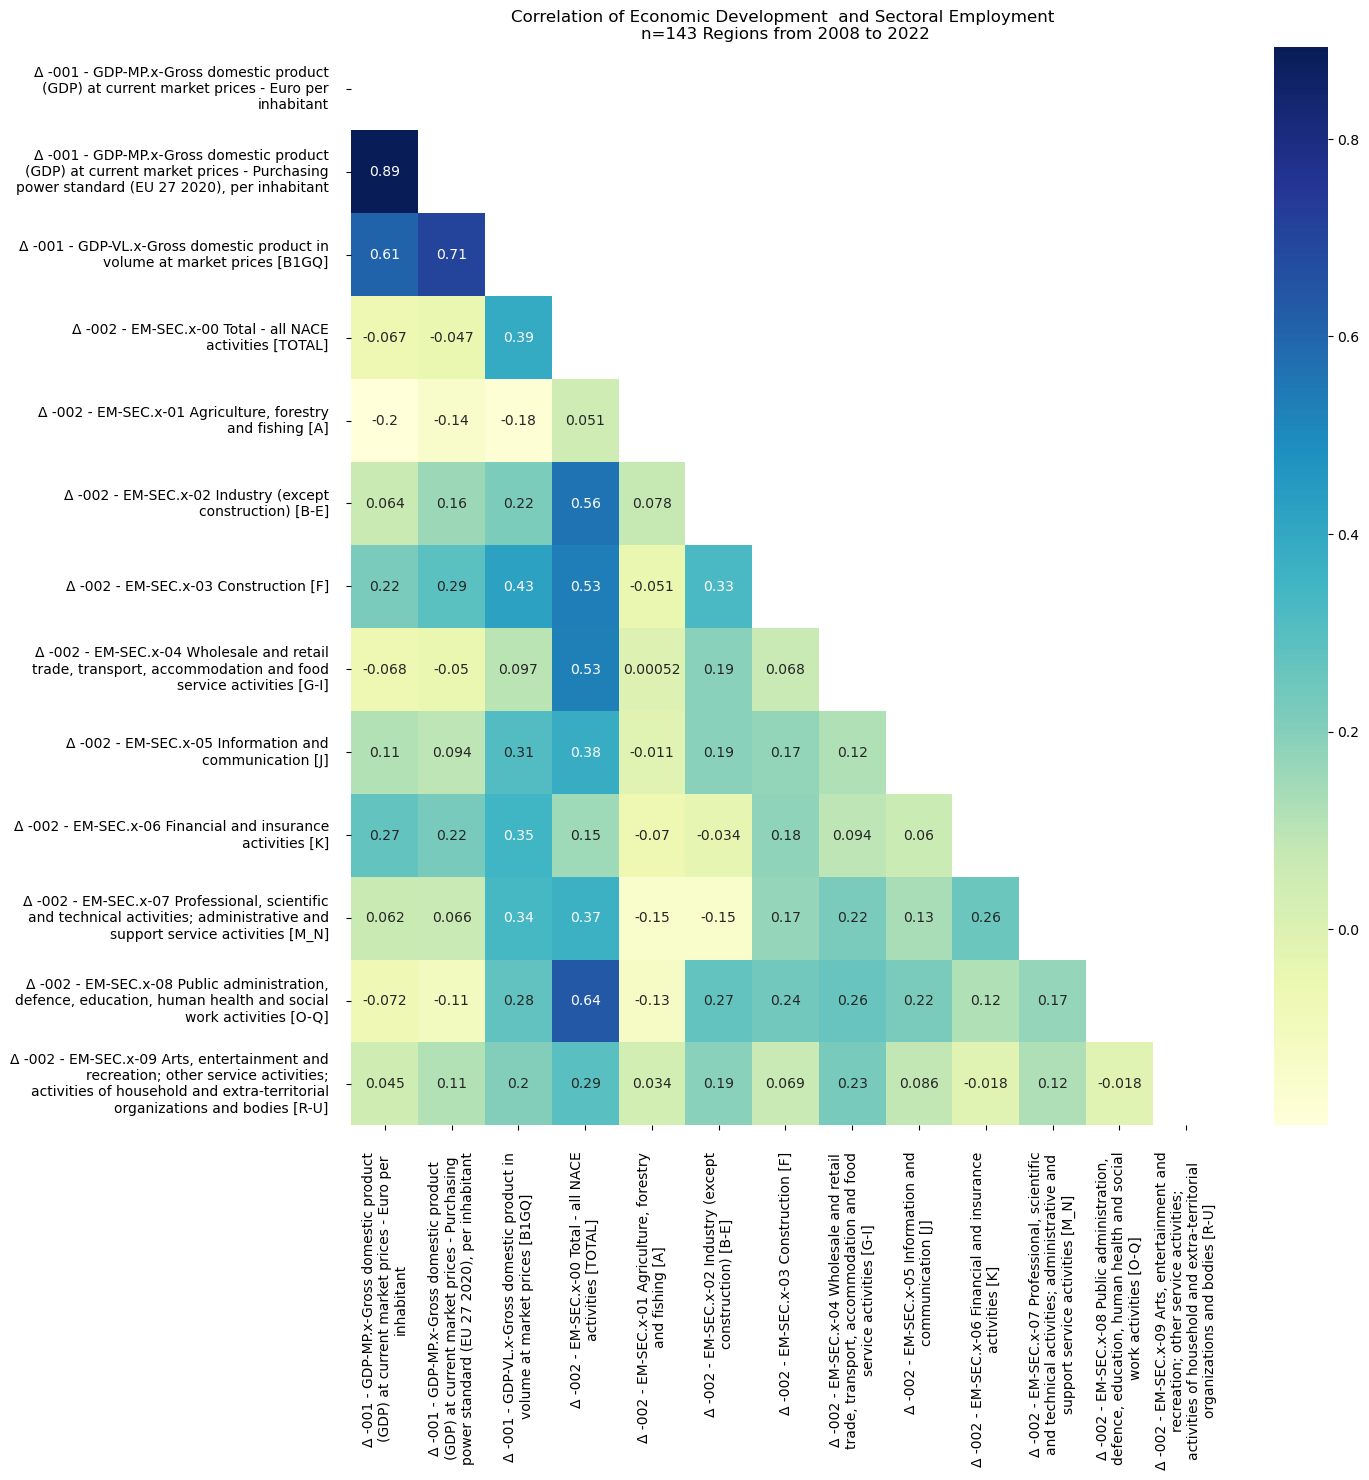

In [19]:
y_half = int((y_range_to_ful - y_range_fr_ful)/2)

data_dict = {} 
unpack_df_dict(data_dict_raw_or, data_dict, key="")

data_dict = select_df_time_range(data_dict, y_range_fr_ful, y_range_to_ful)
print(count_df_values(data_dict))
data_dict_fst = augment_df_delnan_int(data_dict, y_half)
print(count_df_values(data_dict_fst))
data_dict = add_delta(data_dict_fst, y_range_fr_ful, y_range_to_ful)

selected_dfs = []
df_timeframe = select_df(data_dict, selected_dfs, True)
print(df_timeframe.count().sum()-(df_timeframe.shape[0] * 3))

reg_sel_df = aggregate_df_values(df_timeframe)
# Removing outliners;
print('Before outliers:' + str(reg_sel_df.shape))
for col_name in reg_sel_df.iloc[:,2:].columns:
    reg_sel_df = remove_outliers(reg_sel_df, col_name, 0.25)
print('After outliers:' + str(reg_sel_df.shape))

#The process creates a heatmap using searborn for each correlation of a full city dataset
corr_df_pearson = reg_sel_df.corr(method='pearson', numeric_only=True)
ftf_corr = corr_df_pearson

mask = np.triu(np.ones_like(corr_df_pearson, dtype=bool))
fig, ax = plt.subplots(figsize=(fig_x, fig_y))

dataplot01 = sns.heatmap(corr_df_pearson, mask=mask, cmap="YlGnBu", annot=True)
dataplot01.set_yticklabels([textwrap.fill(e, line_break_at) for e in corr_df_pearson.columns], fontdict=corr_fontdict_hor, position=(-0.015, 0))
dataplot01.set_xticklabels([textwrap.fill(e, line_break_at) for e in corr_df_pearson.columns], fontdict=corr_fontdict_vert, position=(0, -0.015))

#plt.suptitle('Correlation of Economic Performance, Regional Eduction Attainment Levels and Demographic Development')
plt.title('Correlation of ' + corr_Indi01 + ' and ' + corr_Indi02 + '\n' + 'n=' + str(reg_sel_df.shape[0]) + ' Regions from ' + str(y_range_fr_ful) + ' to ' + str(y_range_to_ful))
plt.show()


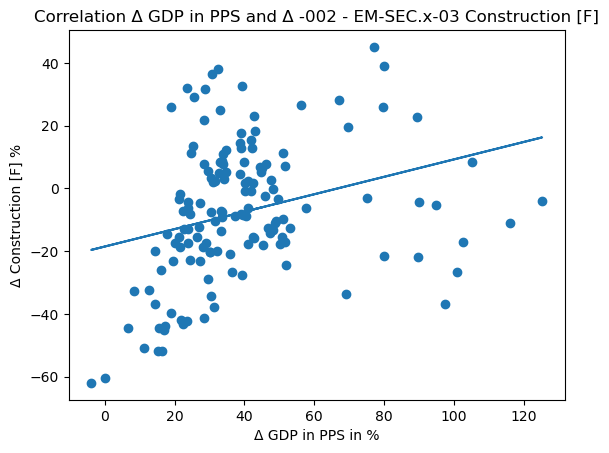

In [20]:
x = reg_sel_df['Δ -001 - GDP-MP.x-Gross domestic product (GDP) at current market prices - Purchasing power standard (EU 27 2020), per inhabitant']
y = reg_sel_df['Δ -002 - EM-SEC.x-03 Construction [F]']

plt.title('Correlation Δ GDP in PPS and Δ -002 - EM-SEC.x-03 Construction [F]')
plt.xlabel('Δ GDP in PPS in %')
plt.ylabel('Δ Construction [F] %')
plt.scatter(x, y)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)

#add trendline to plot
plt.plot(x, p(x))

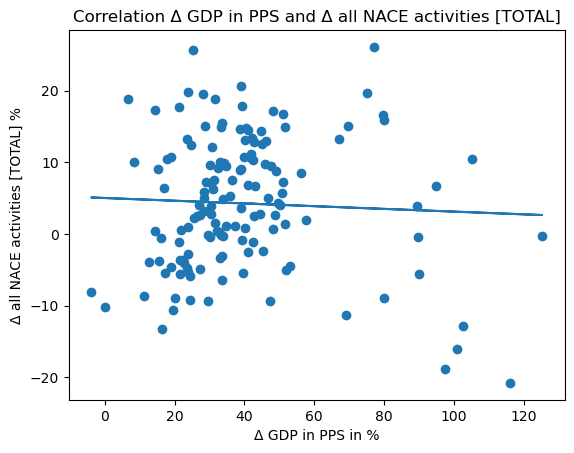

In [21]:
x = reg_sel_df['Δ -001 - GDP-MP.x-Gross domestic product (GDP) at current market prices - Purchasing power standard (EU 27 2020), per inhabitant']
y = reg_sel_df['Δ -002 - EM-SEC.x-00 Total - all NACE activities [TOTAL]']

plt.title('Correlation Δ GDP in PPS and Δ all NACE activities [TOTAL]')
plt.xlabel('Δ GDP in PPS in %')
plt.ylabel('Δ all NACE activities [TOTAL] %')
plt.scatter(x, y)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)

#add trendline to plot
plt.plot(x, p(x))

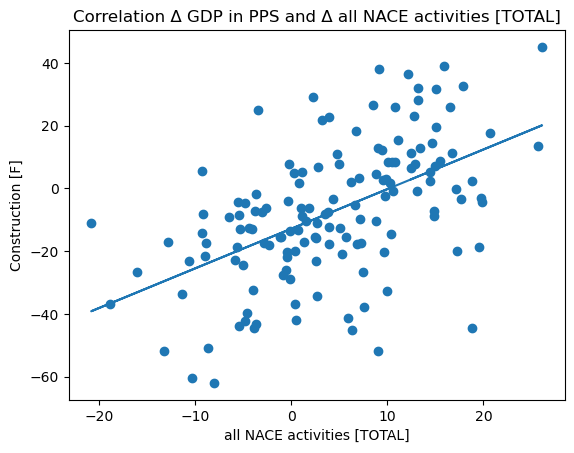

In [22]:
x = reg_sel_df['Δ -002 - EM-SEC.x-00 Total - all NACE activities [TOTAL]']
y = reg_sel_df['Δ -002 - EM-SEC.x-03 Construction [F]']

plt.title('Correlation Δ GDP in PPS and Δ all NACE activities [TOTAL]')
plt.xlabel('all NACE activities [TOTAL]')
plt.ylabel('Construction [F]')
plt.scatter(x, y)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)

#add trendline to plot
plt.plot(x, p(x))

In [23]:
first_region_set = reg_sel_df.iloc[:,:1]
print(first_region_set.head(5).to_markdown())


| Region Code   | Region Name      |
|:--------------|:-----------------|
| AT12          | Niederösterreich |
| AT21          | Kärnten          |
| AT22          | Steiermark       |
| AT31          | Oberösterreich   |
| AT32          | Salzburg         |


## Select Early Dataframe

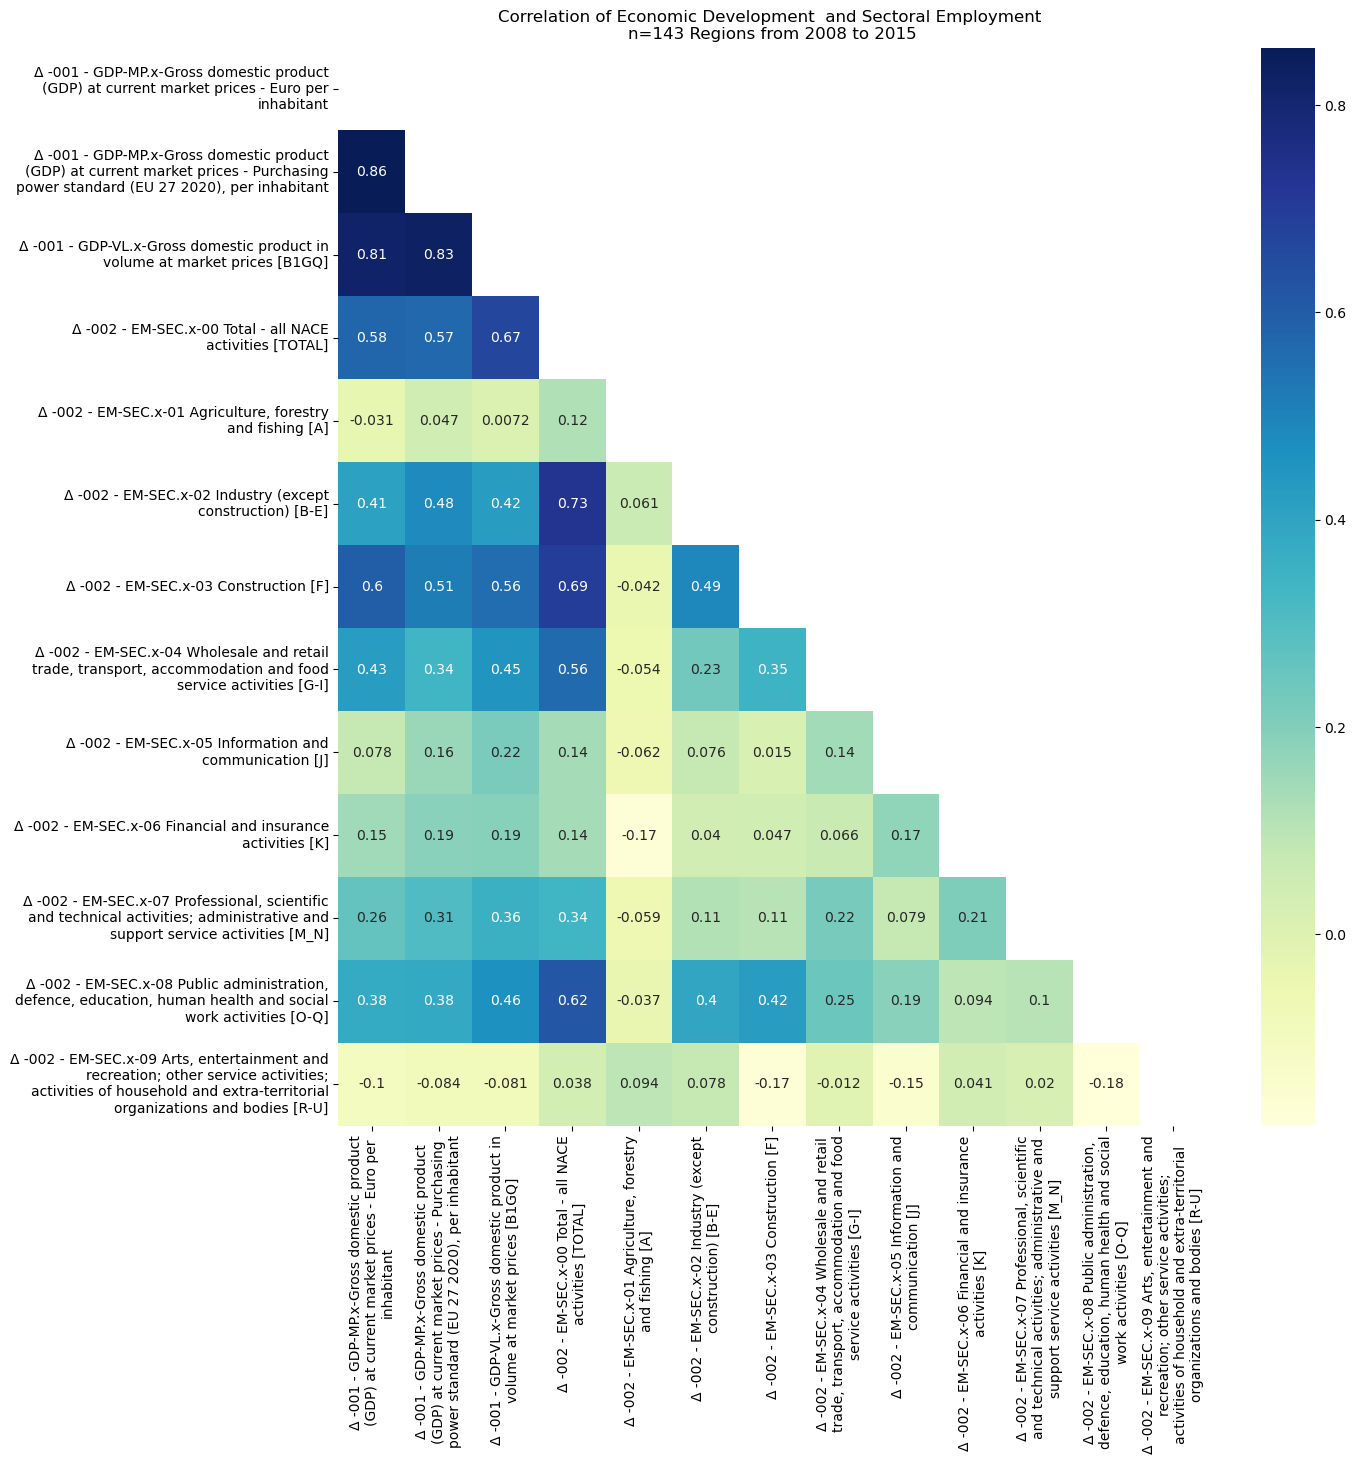

In [24]:
y_half = int((y_range_to_ear - y_range_to_ear)/2)

data_dict = {} 
unpack_df_dict(data_dict_raw_or, data_dict, key="")

#data_dict = augment_df_delnan_int(data_dict, y_half)
data_dict = select_df_time_range(data_dict_fst, y_range_fr_ear, y_range_to_ear)
data_dict = add_delta(data_dict, y_range_fr_ear, y_range_to_ear)

# When using only regions from same set as above
selected_dfs = []
df_timeframe_old = select_df(data_dict, selected_dfs, True)
df_timeframe = df_timeframe_old[df_timeframe_old['Region Code'].isin(first_region_set.index)]
reg_sel_df = aggregate_df_values(df_timeframe)

#selected_dfs = []
#df_timeframe = select_df(data_dict, selected_dfs, True)
#reg_sel_df = aggregate_df_values(df_timeframe)

# Removing outliners;
#print('Before outliers:' + str(reg_sel_df.shape))
#for col_name in reg_sel_df.iloc[:,2:].columns:
#    reg_sel_df = remove_outliers(reg_sel_df, col_name)
#print('After outliers:' + str(reg_sel_df.shape))

#The following process creates a heatmap using searborn for each correlation of a full city dataset
corr_df_pearson = reg_sel_df.corr(method='pearson', numeric_only=True)
etf_corr = corr_df_pearson

mask = np.triu(np.ones_like(corr_df_pearson, dtype=bool))
fig, ax = plt.subplots(figsize=(fig_x, fig_y))
dataplot02 = sns.heatmap(corr_df_pearson, mask=mask, cmap="YlGnBu", annot=True)
dataplot02.set_yticklabels([textwrap.fill(e, line_break_at) for e in corr_df_pearson.columns])
dataplot02.set_xticklabels([textwrap.fill(e, line_break_at) for e in corr_df_pearson.columns])

plt.title('Correlation of ' + corr_Indi01 + ' and ' + corr_Indi02 + '\n' + 'n=' + str(reg_sel_df.shape[0]) + ' Regions from ' + str(y_range_fr_ear) + ' to ' + str(y_range_to_ear))
plt.show()

In [25]:
print(reg_sel_df.head(5).to_markdown())

| Region Code   | Region Name      |   Δ -001 - GDP-MP.x-Gross domestic product (GDP) at current market prices - Euro per inhabitant |   Δ -001 - GDP-MP.x-Gross domestic product (GDP) at current market prices - Purchasing power standard (EU 27 2020), per inhabitant |   Δ -001 - GDP-VL.x-Gross domestic product in volume at market prices [B1GQ] |   Δ -002 - EM-SEC.x-00 Total - all NACE activities [TOTAL] |   Δ -002 - EM-SEC.x-01 Agriculture, forestry and fishing [A] |   Δ -002 - EM-SEC.x-02 Industry (except construction) [B-E] |   Δ -002 - EM-SEC.x-03 Construction [F] |   Δ -002 - EM-SEC.x-04 Wholesale and retail trade, transport, accommodation and food service activities [G-I] |   Δ -002 - EM-SEC.x-05 Information and communication [J] |   Δ -002 - EM-SEC.x-06 Financial and insurance activities [K] |   Δ -002 - EM-SEC.x-07 Professional, scientific and technical activities; administrative and support service activities [M_N] |   Δ -002 - EM-SEC.x-08 Public administration, defence, educati

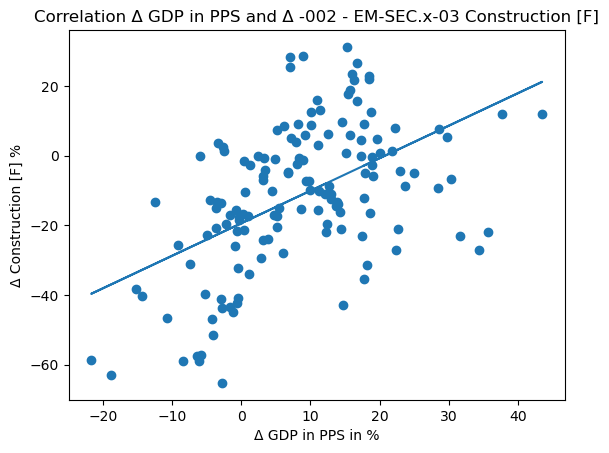

In [26]:
x = reg_sel_df['Δ -001 - GDP-MP.x-Gross domestic product (GDP) at current market prices - Purchasing power standard (EU 27 2020), per inhabitant']
y = reg_sel_df['Δ -002 - EM-SEC.x-03 Construction [F]']

plt.title('Correlation Δ GDP in PPS and Δ -002 - EM-SEC.x-03 Construction [F]')
plt.xlabel('Δ GDP in PPS in %')
plt.ylabel('Δ Construction [F] %')
plt.scatter(x, y)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)

#add trendline to plot
plt.plot(x, p(x))

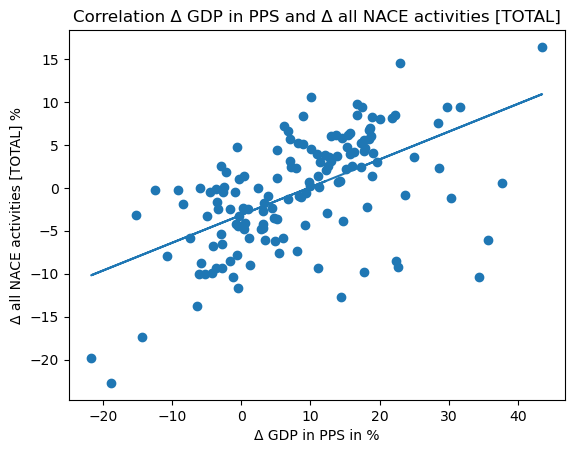

In [27]:
x = reg_sel_df['Δ -001 - GDP-MP.x-Gross domestic product (GDP) at current market prices - Purchasing power standard (EU 27 2020), per inhabitant']
y = reg_sel_df['Δ -002 - EM-SEC.x-00 Total - all NACE activities [TOTAL]']

plt.title('Correlation Δ GDP in PPS and Δ all NACE activities [TOTAL]')
plt.xlabel('Δ GDP in PPS in %')
plt.ylabel('Δ all NACE activities [TOTAL] %')
plt.scatter(x, y)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)

#add trendline to plot
plt.plot(x, p(x))

## Selecte Late Dataframe

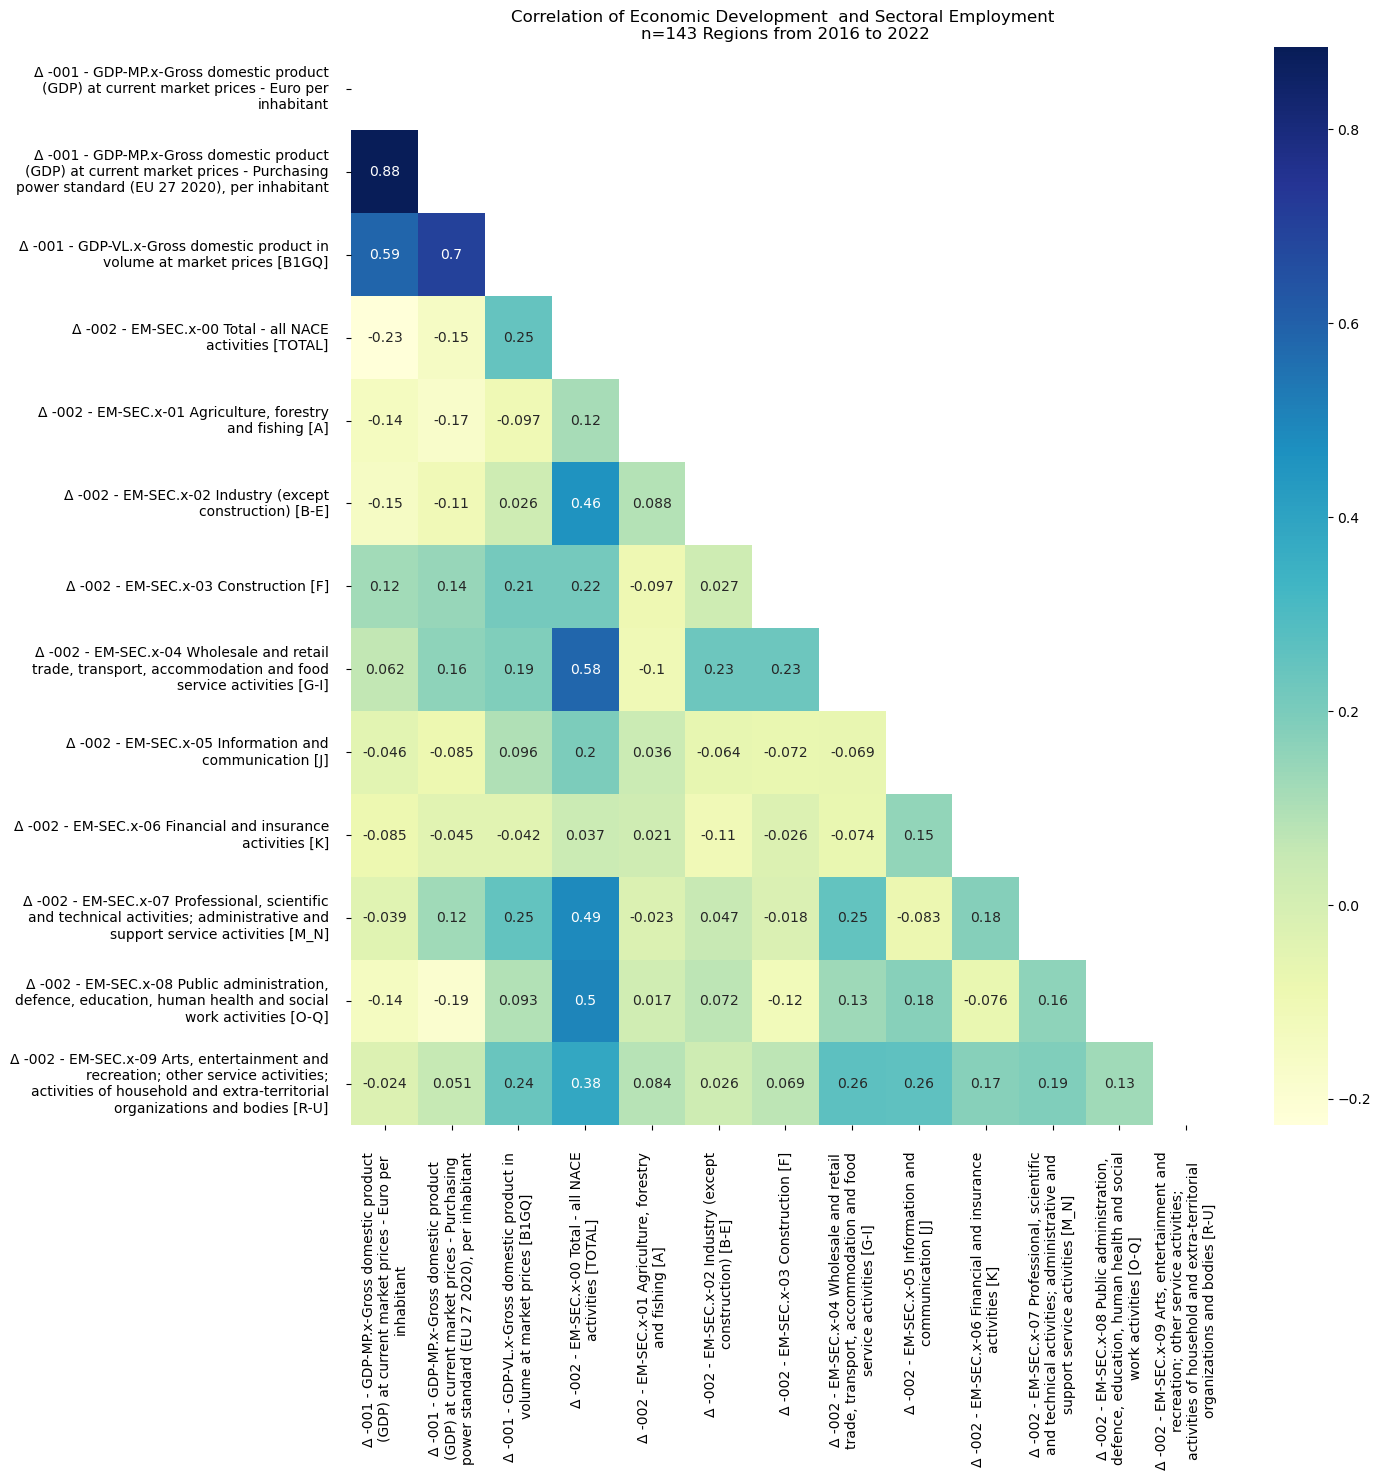

In [28]:
y_half = int((y_range_to_lat - y_range_fr_lat)/2)

data_dict = {} 
unpack_df_dict(data_dict_raw_or, data_dict, key="")

#data_dict = augment_df_delnan_int(data_dict, y_half)
data_dict = select_df_time_range(data_dict_fst, y_range_fr_lat, y_range_to_lat)
data_dict = add_delta(data_dict, y_range_fr_lat, y_range_to_lat)

# When using only regions from same set as above
selected_dfs = []
df_timeframe_old = select_df(data_dict, selected_dfs, True)
df_timeframe = df_timeframe_old[df_timeframe_old['Region Code'].isin(first_region_set.index)]
#print(df_timeframe.head(5).to_markdown())

reg_sel_df = aggregate_df_values(df_timeframe)

#selected_dfs = []
#df_timeframe = select_df(data_dict, selected_dfs, True)
#reg_sel_df = aggregate_df_values(df_timeframe)

# Removing outliners;
#print('Before outliers:' + str(reg_sel_df.shape))
#for col_name in reg_sel_df.iloc[:,2:].columns:
#    reg_sel_df = remove_outliers(reg_sel_df, col_name)
#print('After outliers:' + str(reg_sel_df.shape))

#The following process creates a heatmap using searborn for each correlation of a full city dataset
corr_df_pearson = reg_sel_df.corr(method='pearson', numeric_only=True)
ltf_corr = corr_df_pearson

mask = np.triu(np.ones_like(corr_df_pearson, dtype=bool))
fig, ax = plt.subplots(figsize=(fig_x, fig_y))
dataplot03 = sns.heatmap(corr_df_pearson, mask=mask, cmap="YlGnBu", annot=True)
dataplot03.set_yticklabels([textwrap.fill(e, line_break_at) for e in corr_df_pearson.columns], fontdict=corr_fontdict_hor, position=(-0.015, 0))
dataplot03.set_xticklabels([textwrap.fill(e, line_break_at) for e in corr_df_pearson.columns], fontdict=corr_fontdict_vert, position=(0, -0.015))

plt.title('Correlation of ' + corr_Indi01 + ' and ' + corr_Indi02 + '\n' + 'n=' + str(reg_sel_df.shape[0]) + ' Regions from ' + str(y_range_fr_lat) + ' to ' + str(y_range_to_lat))
plt.show()

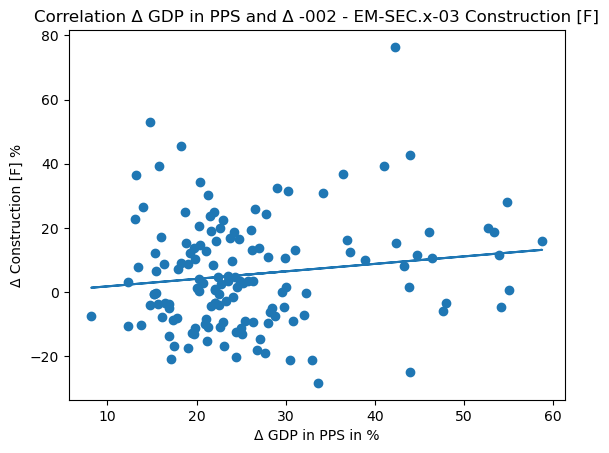

In [29]:
x = reg_sel_df['Δ -001 - GDP-MP.x-Gross domestic product (GDP) at current market prices - Purchasing power standard (EU 27 2020), per inhabitant']
y = reg_sel_df['Δ -002 - EM-SEC.x-03 Construction [F]']

plt.title('Correlation Δ GDP in PPS and Δ -002 - EM-SEC.x-03 Construction [F]')
plt.xlabel('Δ GDP in PPS in %')
plt.ylabel('Δ Construction [F] %')
plt.scatter(x, y)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)

#add trendline to plot
plt.plot(x, p(x))

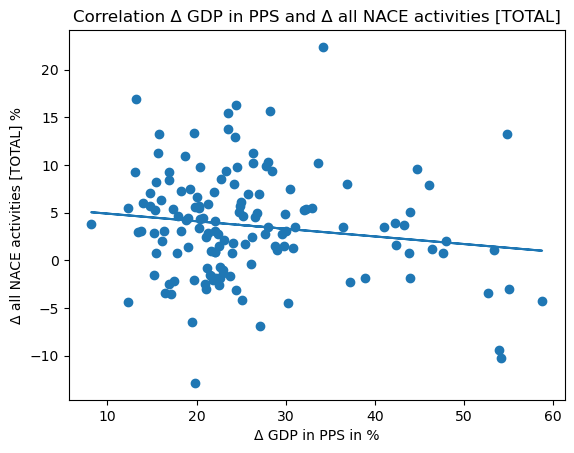

In [30]:
x = reg_sel_df['Δ -001 - GDP-MP.x-Gross domestic product (GDP) at current market prices - Purchasing power standard (EU 27 2020), per inhabitant']
y = reg_sel_df['Δ -002 - EM-SEC.x-00 Total - all NACE activities [TOTAL]']

plt.title('Correlation Δ GDP in PPS and Δ all NACE activities [TOTAL]')
plt.xlabel('Δ GDP in PPS in %')
plt.ylabel('Δ all NACE activities [TOTAL] %')
plt.scatter(x, y)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)

#add trendline to plot
plt.plot(x, p(x))

In [31]:
df_delta_ftf_etf = etf_corr - ftf_corr 
df_delta_ftf_ltf = ltf_corr - ftf_corr 
df_delta_ltl_etf = ltf_corr - etf_corr 


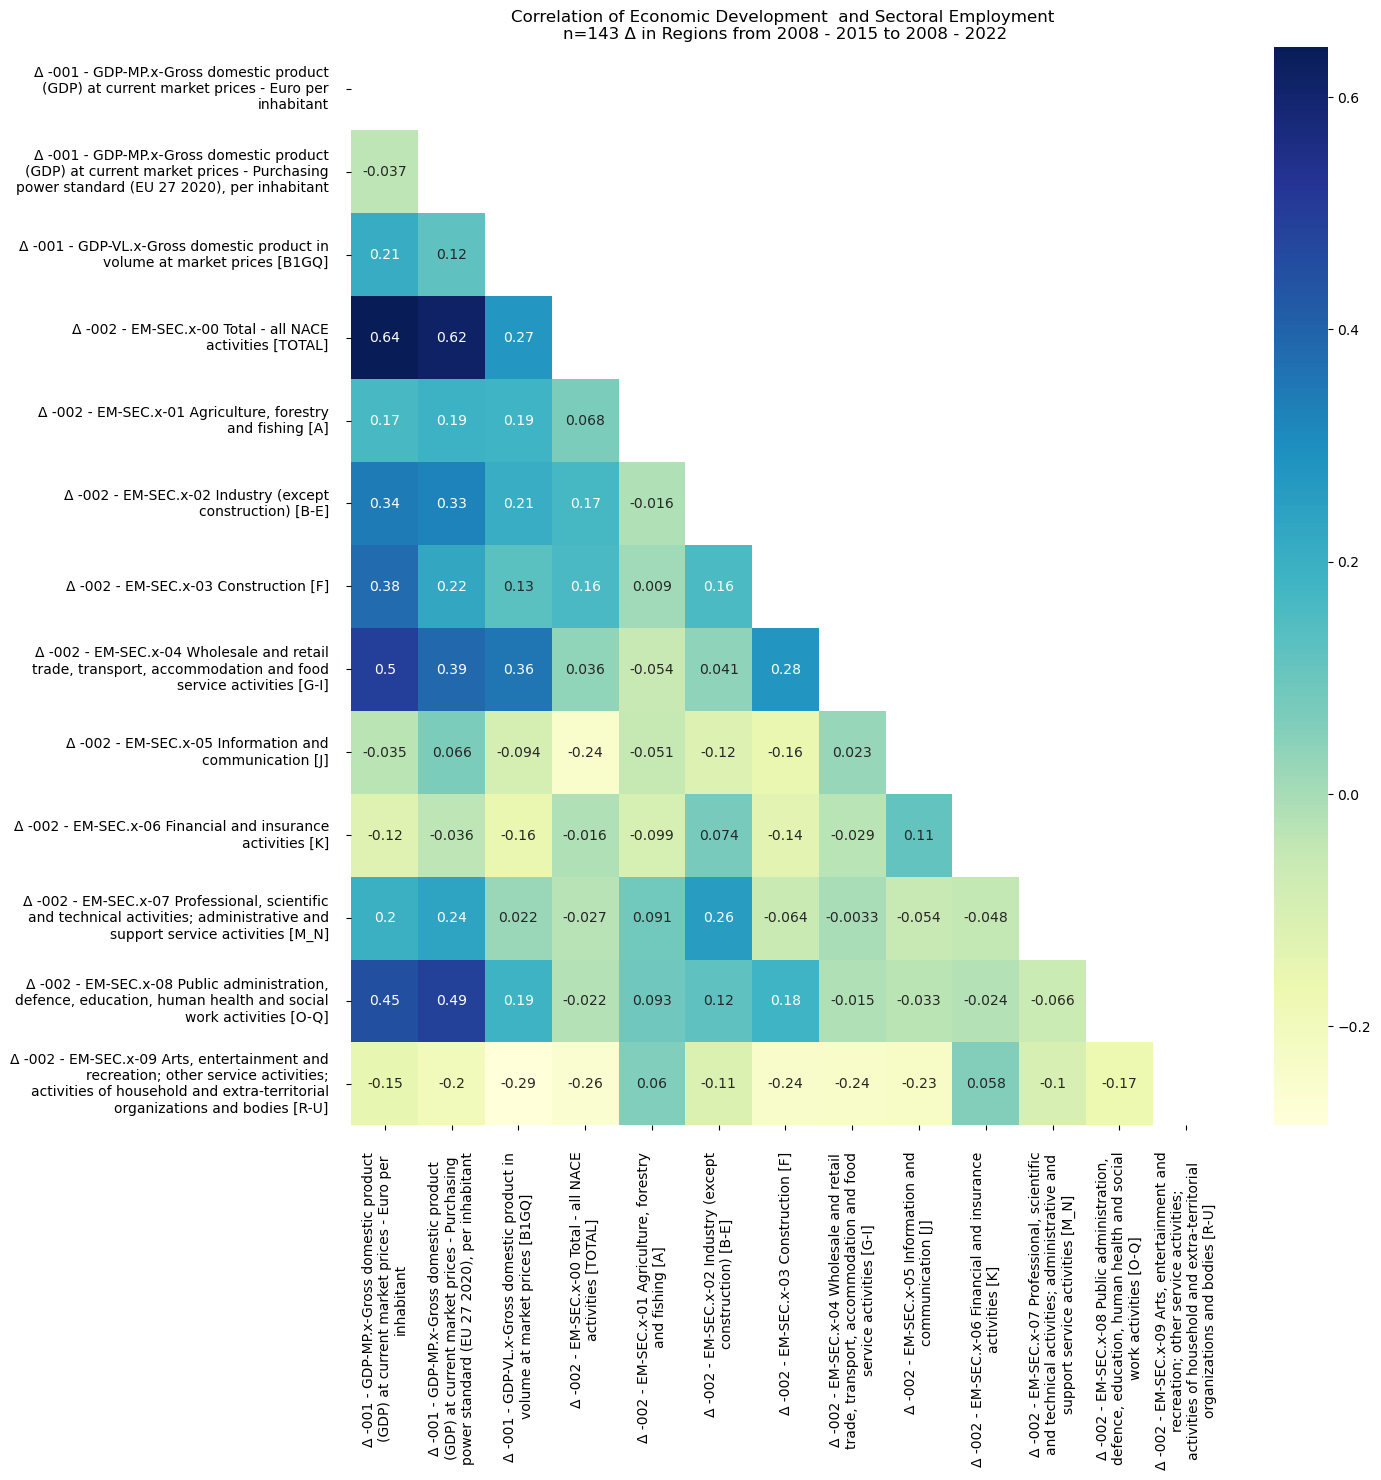

In [32]:
fig, ax = plt.subplots(figsize=(fig_x, fig_y))
dataplot04 = sns.heatmap(df_delta_ftf_etf, mask=mask, cmap="YlGnBu", annot=True)
dataplot04.set_yticklabels([textwrap.fill(e, line_break_at) for e in corr_df_pearson.columns], fontdict=corr_fontdict_hor, position=(-0.015, 0))
dataplot04.set_xticklabels([textwrap.fill(e, line_break_at) for e in corr_df_pearson.columns], fontdict=corr_fontdict_vert, position=(0, -0.015))
plt.title('Correlation of ' + corr_Indi01 + ' and ' + corr_Indi02 + '\n' + 'n=' + str(reg_sel_df.shape[0]) + ' Δ in Regions from ' + str(y_range_fr_ear) + ' - ' + str(y_range_to_ear) + ' to ' + str(y_range_fr_ful) + ' - ' + str(y_range_to_ful))
plt.show()

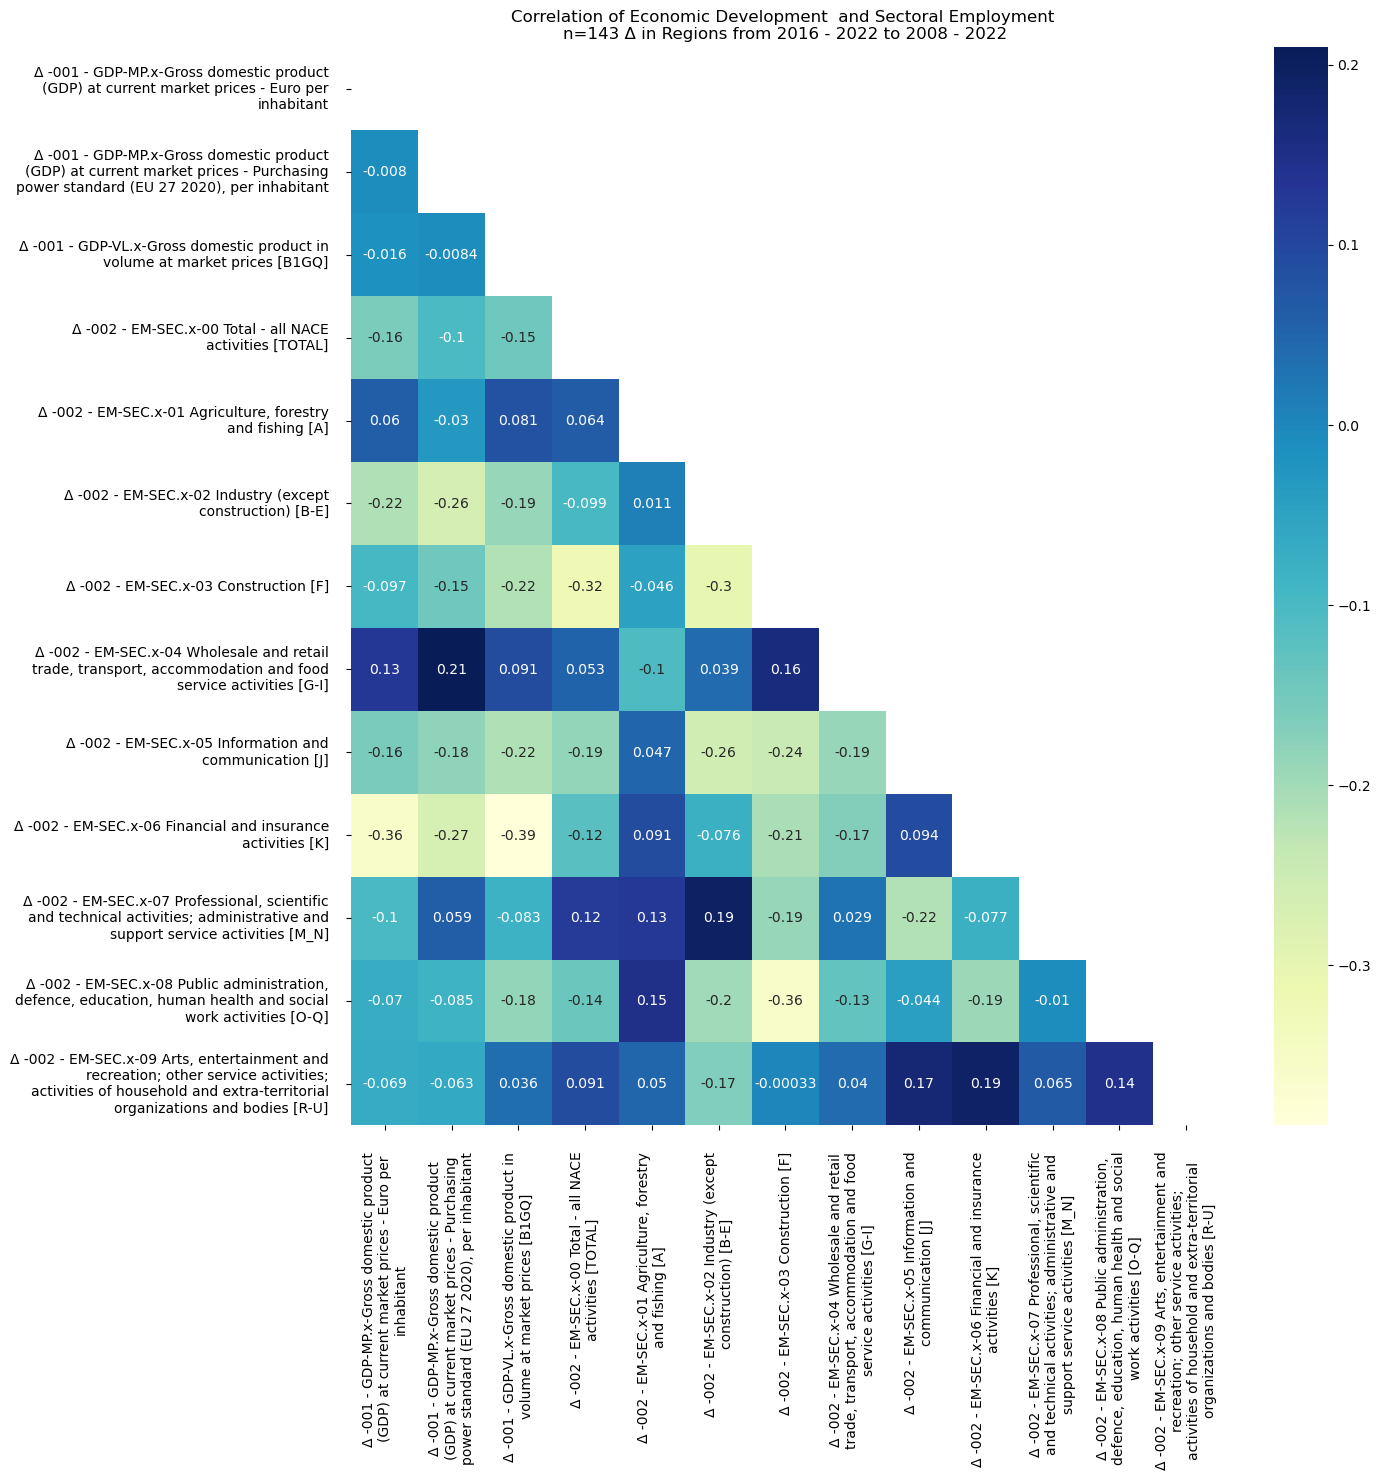

In [33]:
fig, ax = plt.subplots(figsize=(fig_x, fig_y))
dataplot05 = sns.heatmap(df_delta_ftf_ltf, mask=mask, cmap="YlGnBu", annot=True)
dataplot05.set_yticklabels([textwrap.fill(e, line_break_at) for e in corr_df_pearson.columns], fontdict=corr_fontdict_hor, position=(-0.015, 0))
dataplot05.set_xticklabels([textwrap.fill(e, line_break_at) for e in corr_df_pearson.columns], fontdict=corr_fontdict_vert, position=(0, -0.015))
plt.title('Correlation of ' + corr_Indi01 + ' and ' + corr_Indi02 + '\n' + 'n=' + str(reg_sel_df.shape[0]) + ' Δ in Regions from ' + str(y_range_fr_lat) + ' - ' + str(y_range_to_lat) + ' to ' + str(y_range_fr_ful) + ' - ' + str(y_range_to_ful))
plt.show()

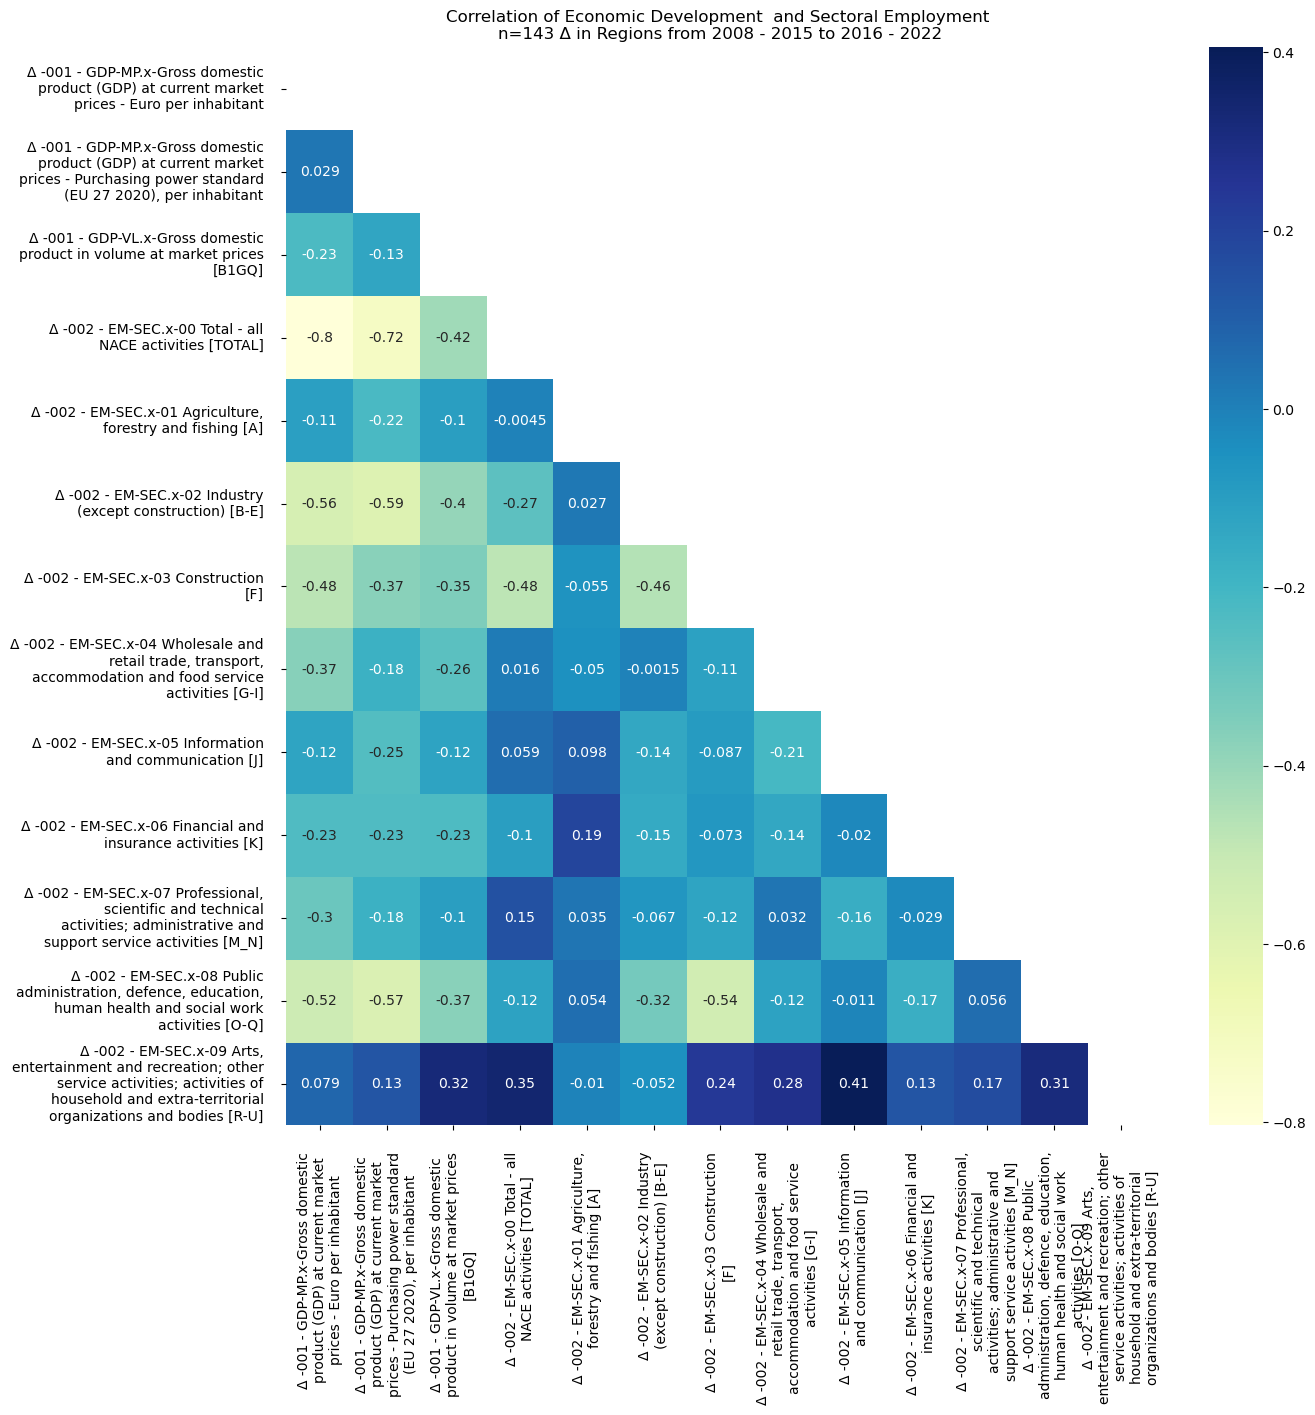

In [34]:
fig, ax = plt.subplots(figsize=(fig_x, fig_y))
dataplot06 = sns.heatmap(df_delta_ltl_etf, mask=mask, cmap="YlGnBu", annot=True)
dataplot06.set_yticklabels([textwrap.fill(e, 35) for e in corr_df_pearson.columns], fontdict=corr_fontdict_hor, position=(-0.015, 0))
dataplot06.set_xticklabels([textwrap.fill(e, 35) for e in corr_df_pearson.columns], fontdict=corr_fontdict_vert, position=(0, -0.015))

plt.title('Correlation of ' + corr_Indi01 + ' and ' + corr_Indi02 + '\n' + 'n=' + str(reg_sel_df.shape[0]) + ' Δ in Regions from ' + str(y_range_fr_ear) + ' - ' + str(y_range_to_ear) + ' to ' + str(y_range_fr_lat) + ' - ' + str(y_range_to_lat))
plt.show()


## Comp

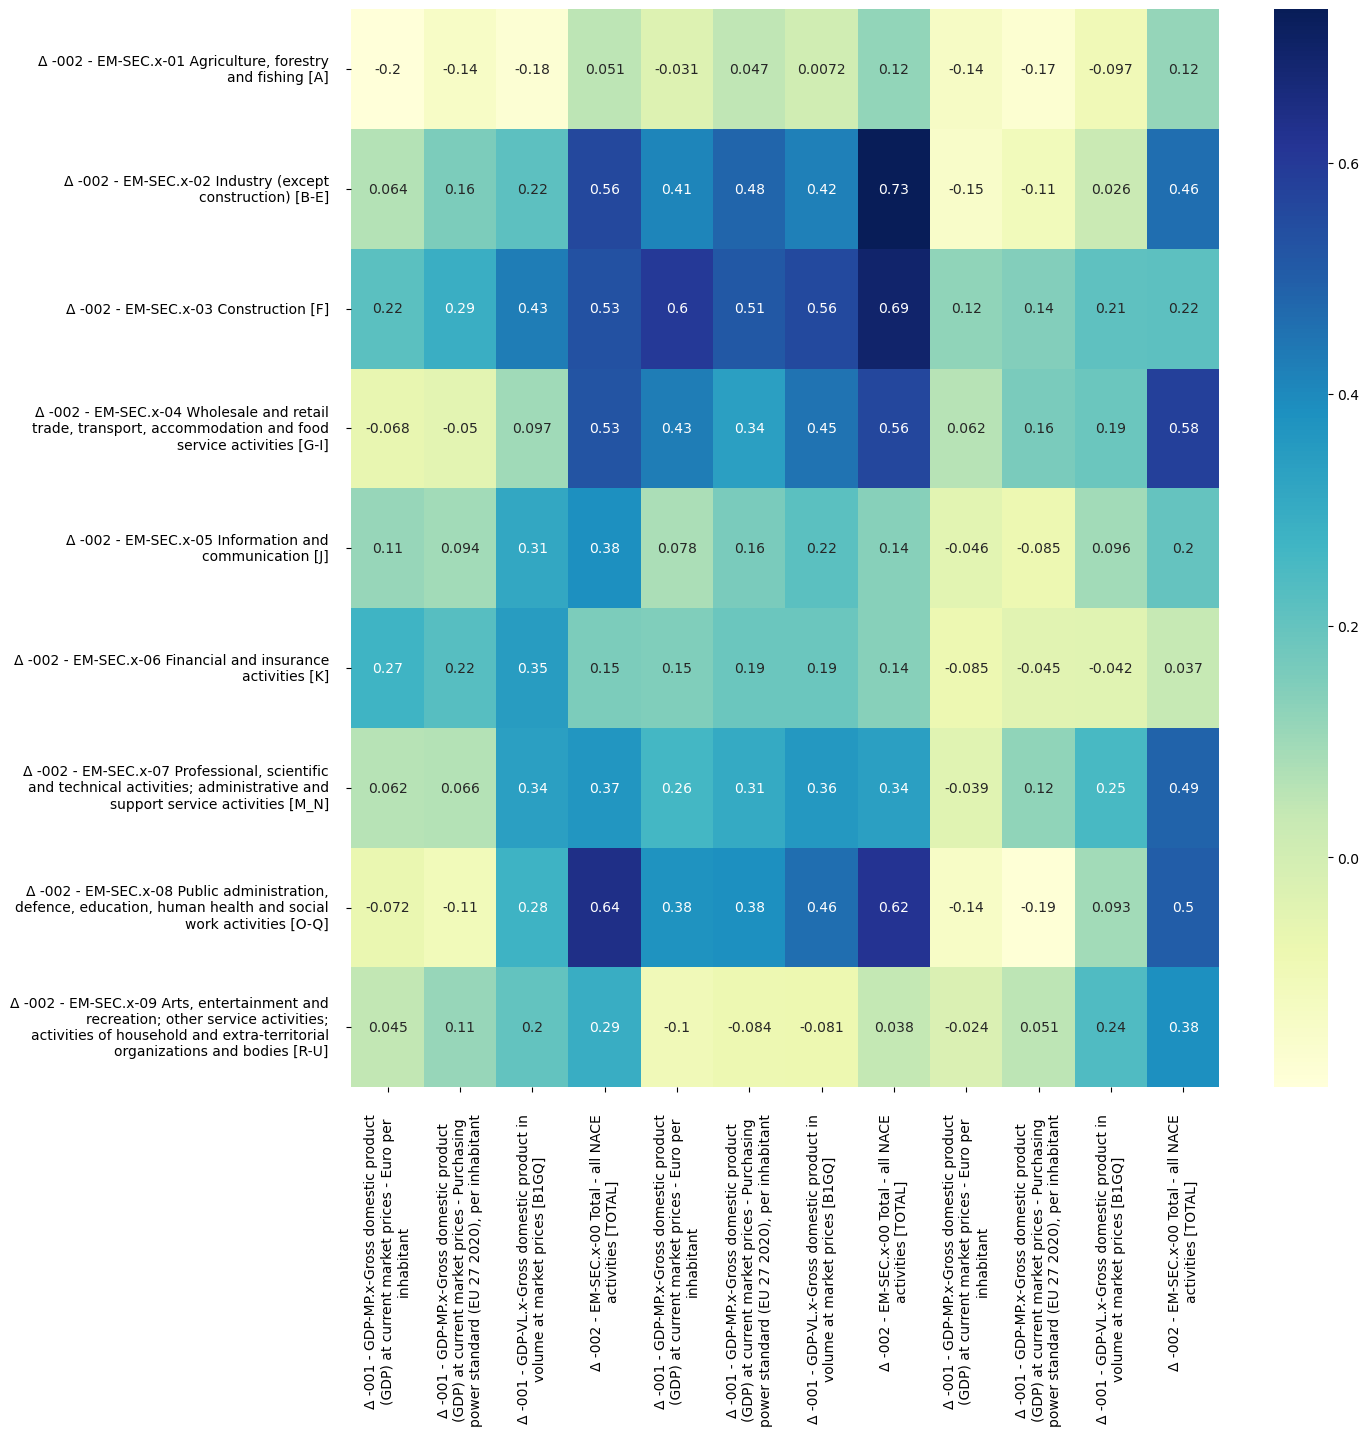

In [35]:
row_start = 4
col_end = 4

cmp_corr_ftf_df = ftf_corr.iloc[row_start:,0:col_end]
cmp_corr_eft_df = etf_corr.iloc[row_start:,0:col_end]
cmp_corr_lft_df = ltf_corr.iloc[row_start:,0:col_end]

cmp_corr_df = pd.concat([cmp_corr_ftf_df, cmp_corr_eft_df, cmp_corr_lft_df], axis='columns')

fig, ax = plt.subplots(figsize=(fig_x, fig_y))
dataplot001 = sns.heatmap(cmp_corr_df, cmap="YlGnBu", annot=True)

dataplot001.set_xticklabels([textwrap.fill(e, line_break_at) for e in cmp_corr_df.columns], fontdict=corr_fontdict_vert, position=(0, -0.015))
dataplot001.set_yticklabels([textwrap.fill(e, line_break_at) for e in cmp_corr_df.T.columns], fontdict=corr_fontdict_hor, position=(-0.015, 0))
plt.show()


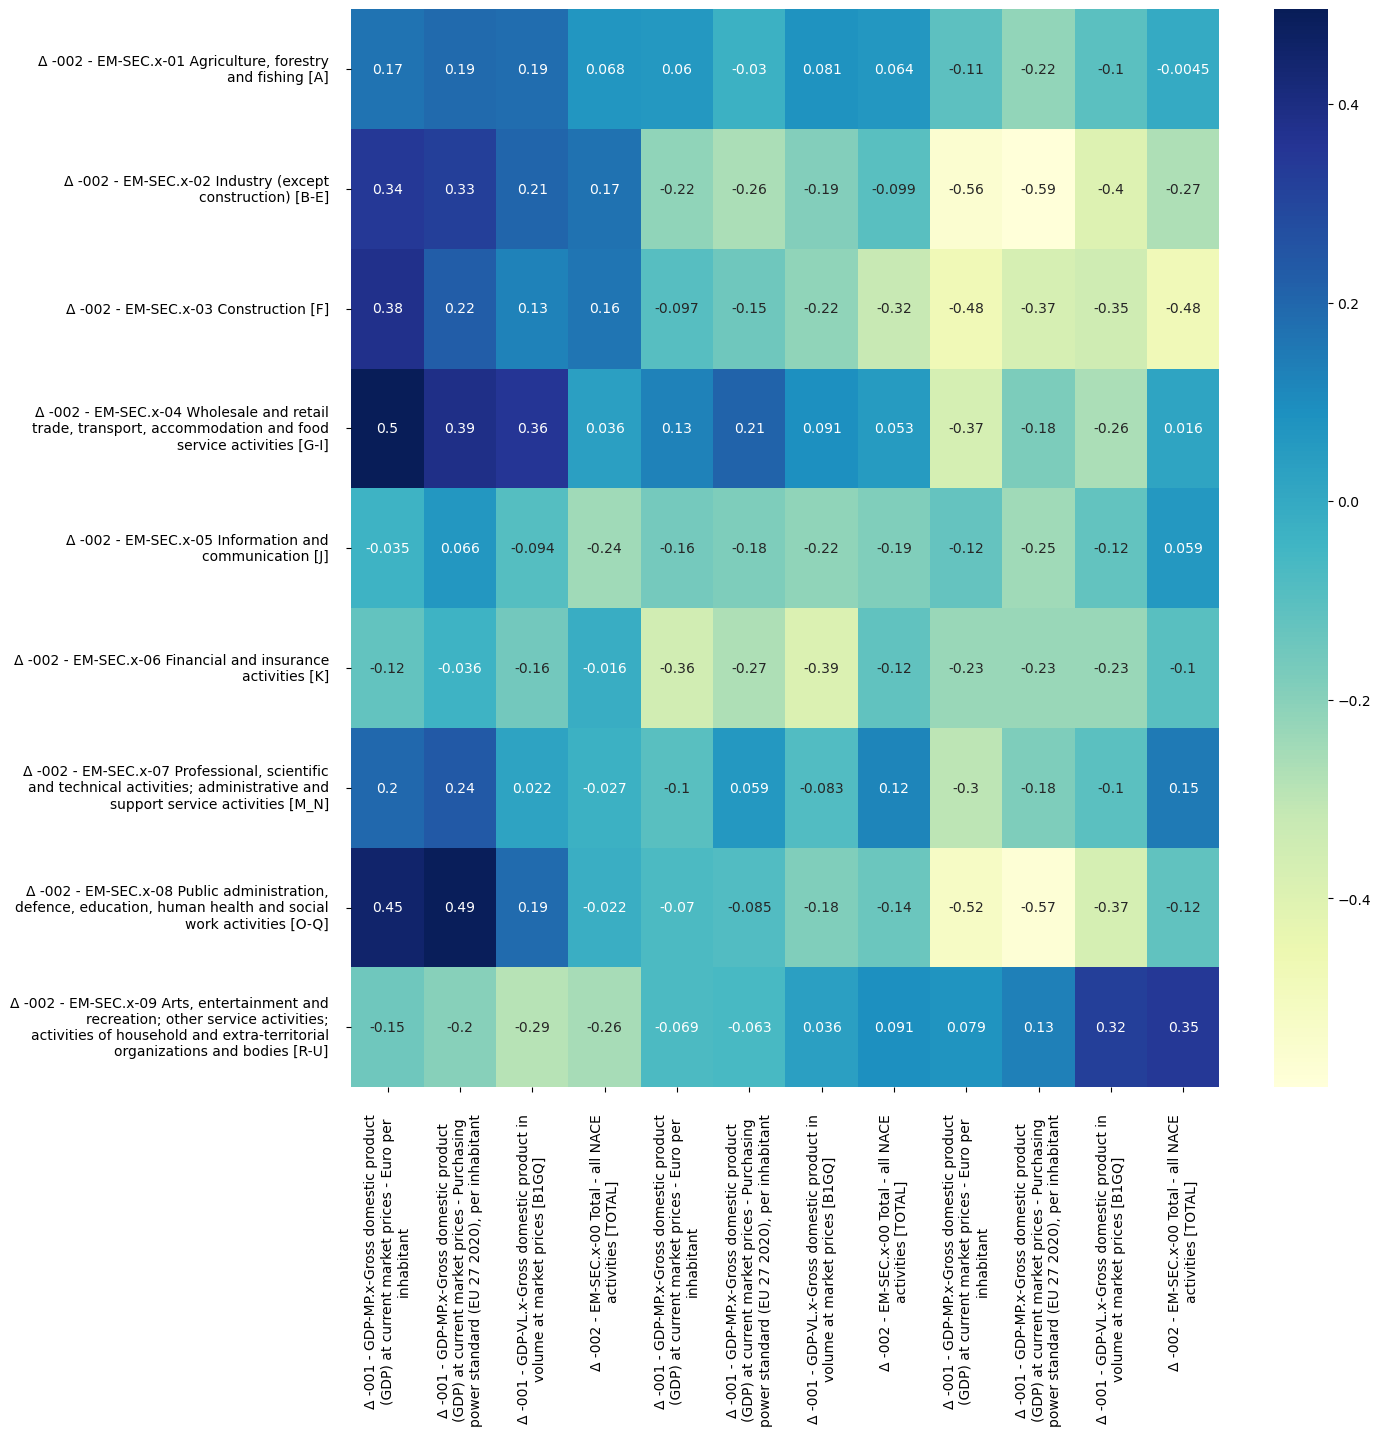

In [36]:
row_start = 4
col_end = 4

cmp_df_delta_ftf_etf = df_delta_ftf_etf.iloc[row_start:,0:col_end]
cmp_df_delta_ftf_ltf = df_delta_ftf_ltf.iloc[row_start:,0:col_end]
cmp_df_delta_ltl_etf = df_delta_ltl_etf.iloc[row_start:,0:col_end]

cmp_df_corr_df = pd.concat([cmp_df_delta_ftf_etf, cmp_df_delta_ftf_ltf, cmp_df_delta_ltl_etf], axis='columns')

fig, ax = plt.subplots(figsize=(fig_x, fig_y))
dataplot001 = sns.heatmap(cmp_df_corr_df, cmap="YlGnBu", annot=True)

dataplot001.set_xticklabels([textwrap.fill(e, line_break_at) for e in cmp_df_corr_df.columns], fontdict=corr_fontdict_vert, position=(0, -0.015))
dataplot001.set_yticklabels([textwrap.fill(e, line_break_at) for e in cmp_df_corr_df.T.columns], fontdict=corr_fontdict_hor, position=(-0.015, 0))
plt.show()

# Education Development

## Education


 ------------- 

|    | Data Type                                                                                                                                                     |     2008 |     2009 |     2010 |     2011 |     2012 |     2013 |     2014 |     2015 |     2016 |     2017 |     2018 |     2019 |     2020 |     2021 |     2022 |
|---:|:--------------------------------------------------------------------------------------------------------------------------------------------------------------|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|
|  1 | -002 - EM-SEC.x-01 Agriculture, forestry and fishing [A]                                                                                                      |  31.1294 |  30.1692 |  29.9671 |  29.3026 |  28.7621 |  28.2815 |  27.9914 |  27.9135 |  27.2434 |  26.5217 |  25.6374 |  25.1864 |  24.7681 |  24.4809

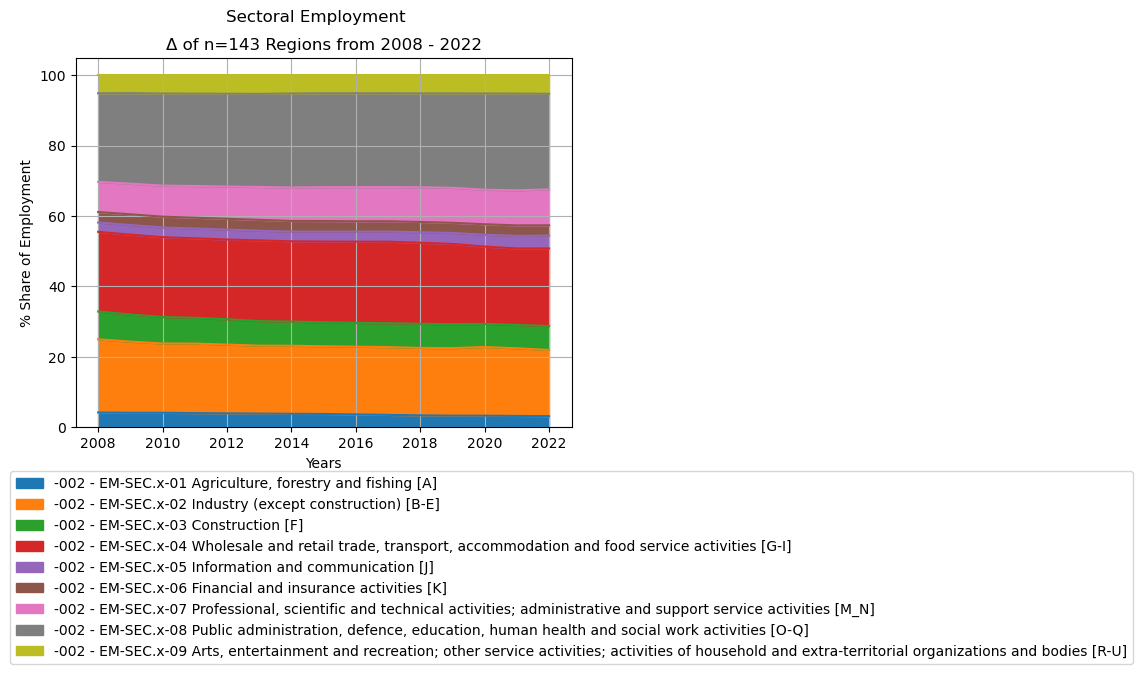

In [37]:
#data_dict = add_delta(data_dict_fst, y_range_fr_ful, y_range_to_ful)
#selected_dfs = []
#df_timeframe = select_df(data_dict_fst, selected_dfs, True)

selected_dfs = []
df_timeframe_old = select_df(data_dict_fst, selected_dfs, True)
df_timeframe = df_timeframe_old[df_timeframe_old['Region Code'].isin(first_region_set.index)]

edu_df = df_timeframe[df_timeframe[cdc_name].str.contains('EM-SEC')]
cpv_list = sorted(set(pd.unique(edu_df[cdc_name])))
result_df = pd.DataFrame()

for cpv_value in cpv_list:
    tmp_df = edu_df[edu_df[cdc_name] == cpv_value]
    tmp_df = tmp_df.mean(numeric_only=True).to_frame().T
    tmp_df.insert(0, str(cdc_name), str(cpv_value), allow_duplicates=True)
    result_df = pd.concat([result_df, tmp_df], axis=0)

result_df = result_df.reset_index(drop=True)
#result_df = result_df.drop(0)
#print(result_df.head(30).to_markdown())

result_df = result_df.drop(0)
result_df_tmp = result_df
#result_df_tmp = result_df_tmp.iloc[:, 1:]
#print(result_df_tmp.head(10).to_markdown())
#result_df_tmp = result_df_tmp.sum(axis='columns', numeric_only=True)
#print(result_df_tmp.sum(axis=0))

#result_df_tmp.loc['Total',:] = result_df_tmp.sum(axis=0, numeric_only=True)

print('\n ------------- \n')
print(result_df_tmp.head(20).to_markdown())
print('\n ------------- \n')
#print(result_df.head(20).to_markdown())

for colName in result_df_tmp:
    if colName.isdigit():
        total = result_df_tmp[colName].sum()
        result_df_tmp[colName] = (result_df_tmp[colName]/total)*100 
    #temp_df = pd.concat([temp_df, colData], axis=1)

print(result_df_tmp.head(20).to_markdown())
cpv_list = sorted(set(pd.unique(result_df_tmp[cdc_name])))

df_fr_yr = result_df_tmp.loc[:, str(y_range_fr_ful)]
df_to_yr = result_df_tmp.loc[:, str(y_range_to_ful)]
delt_ab = df_to_yr.sub(df_fr_yr)
delt_pr = ((df_to_yr.sub(df_fr_yr)).div(df_fr_yr)).mul(100)

delta = pd.concat([delt_ab, delt_pr], axis=1)
delta.columns = ['Delta Abs.', 'Delta %']
result_df_delta = pd.concat([result_df.iloc[:,:1], delta], axis=1)
result_df_delta = result_df_delta.reset_index()
print(result_df_delta.head(30).to_markdown())
print('\n\n')

print('\n\n')
print(result_df_delta.head(30).to_markdown())
print('\n\n')

result_df_num = result_df_tmp.iloc[:,1:].T
result_df_num.columns = cpv_list
ax = result_df_num.plot(kind='area', stacked=True)
plt.suptitle('Sectoral Employment')
plt.ylabel('% Share of Employment')
plt.xlabel('Years')
plt.title('Δ of n=' + str(reg_sel_df.shape[0]) + ' Regions from ' + str(y_range_fr_ful) + ' - ' + str(y_range_to_ful))
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc='upper center', bbox_to_anchor=(1, -0.1))

plt.grid()
plt.show()

In [38]:
print(df_timeframe.head(5).to_markdown())

test_df = df_timeframe[df_timeframe['Data Type'] == '-01.xlsx-Income of households [EUR_HAB]']
print(test_df.head(5).to_markdown())
print(test_df.shape)

|    | Region Code   | Region Name           | Data Type                                                                                   |   2008 |   2009 |   2010 |   2011 |   2012 |   2013 |   2014 |   2015 |   2016 |   2017 |   2018 |   2019 |   2020 |   2021 |   2022 |
|---:|:--------------|:----------------------|:--------------------------------------------------------------------------------------------|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|
|  1 | BE21          | Prov. Antwerpen       | -001 - GDP-MP.x-Gross domestic product (GDP) at current market prices - Euro per inhabitant |  38900 |  37400 |  38800 |  39900 |  40600 |  41100 |  42000 |  43600 |  44900 |  46100 |  47400 |  49100 |  47900 |  52400 |  56400 |
|  3 | BE23          | Prov. Oost-Vlaanderen | -001 - GDP-MP.x-Gross domestic product (GDP) at current market prices - Euro per inhabitant |  29300 |  28900 |  29900 |  308